In [1]:
import folium
import geopandas as gpd
import pandas as pd
import numpy as np
import re
from selenium import webdriver
from selenium.webdriver.common.by import By

# webdriver 업데이팅
driver = webdriver.Chrome()

# 코로나 사이트 접속 후 크롤링
driver.get('https://ncov.kdca.go.kr/bdBoardList_Real.do?brdId=1&brdGubun=13&ncvContSeq=&contSeq=&board_id=&gubun=')
corona = driver.find_element(By.XPATH, '//*[@id="main_maplayout"]')

# raw data를 정규표현식과 comprehesion으로 사전형태 가공
corona = {value.split()[0]:value.split()[1] for value in re.findall('[\w]+\s[\d,]+' , corona.text)}

# 확진자수는 각자 수집(대략적으로 최근 데이터)하여 [시도별_인구.csv] 데이터에 추가한 후 데이터프레임 출력(데이터 확인용)
pop = pd.read_csv('./시도별_인구.csv', encoding='CP949')
pop = pop.astype({'sido_id':'str'})
pop['코로나수'] = np.nan

# 시도별 인구와 코로나수 합치기
for i in range(len(pop)):
    try : pop.loc[i, '코로나수'] = corona[pop.loc[i,'시도']]  #검역, 전국 등의 단어를 제거할 수도 있지만 예외처리로 한번에 처리
    except : pass

# 문자열 ,로 되어있는 것을 int형태로 변환하는 처리
pop['코로나수'] = pop['코로나수'].apply(lambda x : int(''.join(str(x).split(','))))
pop

,시도,sido_id,총인구,남자,여자,코로나수
0,서울,11,9424873,4567739,4857134,6187279
1,부산,26,3316107,1618749,1697358,1863514
2,대구,27,2362880,1162217,1200663,1372977
3,인천,28,2969502,1486300,1483202,1839651
4,광주,29,1429816,706724,723092,921607
5,대전,30,1445806,721037,724769,923479
6,울산,31,1110074,570113,539961,668534
7,세종,36,384496,191769,192727,251455
8,경기,41,13596091,6842226,6753865,8564540
9,강원,42,1535373,772297,763076,926744


In [2]:
# 시도 경계 데이터를 불러와 좌표계 변경처리
kr_sido = gpd.read_file('./CTPRVN_202302', encoding='cp949')
kr_sido = kr_sido.rename(columns={'CTPRVN_CD':'sido_id'})
kr_sido.crs='epsg:5179'
kr_sido.to_crs(epsg=4326).head(2)

# 시각화
m = folium.Map(location=[35.7, 128], zoom_start=6, width=500, height=400)
folium.Choropleth(
    geo_data=kr_sido,
    data=pop,
    columns=['sido_id', "코로나수"],
    key_on="feature.properties.sido_id",
    fill_color="Reds",
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name="코로나수"
).add_to(m)
m

폴리움 실행화면 캡쳐본 : 코드돌리면 이대로 나옵니다
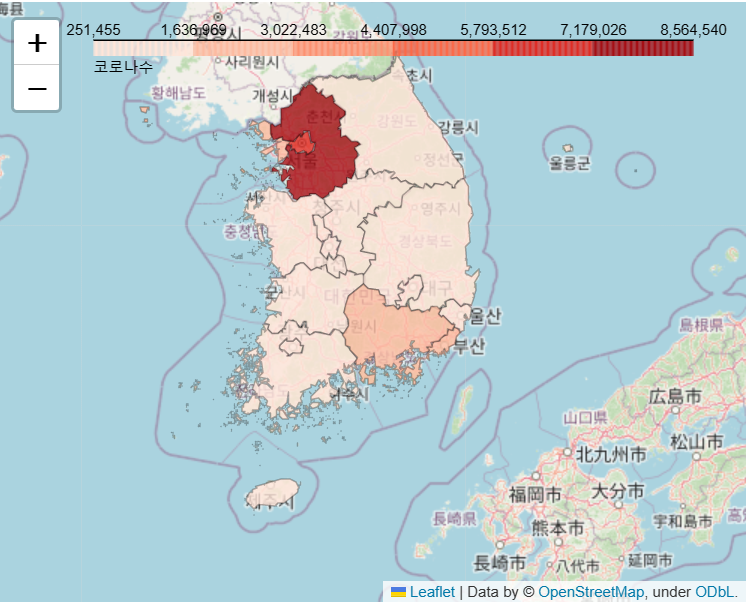